## Setup

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
 # This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
 
import ds_input, ds_model

%reload_ext autoreload
%autoreload 2

## Read Datasets
Reads data from sat-6-full.mat. Returning object contains:
- data_sets.train
- data_sets.validation
- data_sets.test

In [2]:
# load images
data_sets = ds_input.read_data_sets()

### sample images

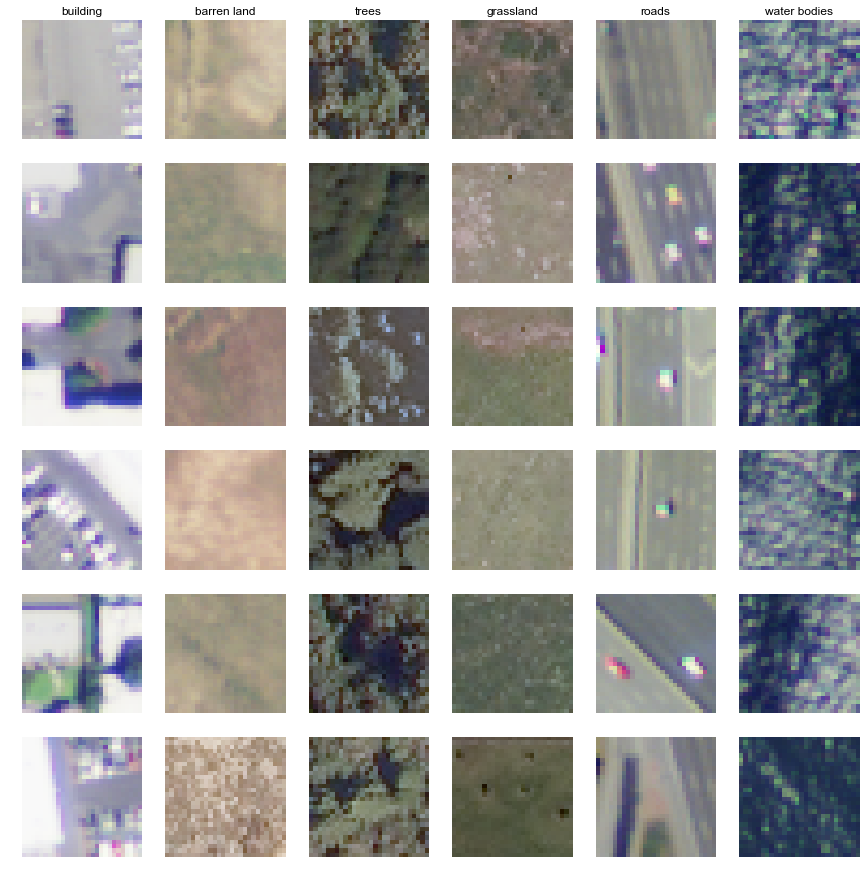

In [3]:
tr_x = data_sets.train.images
tr_y = data_sets.train.labels
classes = ['building', 'barren land', 'trees', 'grassland', 'roads', 'water bodies']
num_classes = len(classes)
samples_per_class = 6
for y, cls in enumerate(classes):
    #tr_y_sc = np.transpose(np.nonzero(tr_y))[:,1]
    idxs = np.flatnonzero(tr_y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(tr_x[idx].astype('float32'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Build the Graph
After loading data, graph of operations needs to be built. 3 components are required to build a graph:
- inference
- loss
- traning

### Default setup for DEEPSAT model

In [4]:
import tensorflow as tf

# Basic model parameters as external flags.
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('max_steps', 2000, 'Number of steps to run trainer.')
flags.DEFINE_integer('batch_size', 100, 'Number of images to process in a batch.')
flags.DEFINE_string('train_dir', 'data', 'Directory to put the training data.')

# Constants describing the data
IMAGE_SIZE = 28
CHANNEL = 3

# Constants describing the training process.
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
NUM_EPOCHS_PER_DECAY = 350.0      # Epochs after which learning rate decays.
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.

# Now placeholders are needed to hold the images and labels.
images_placeholder = tf.placeholder(tf.float32, shape=(FLAGS.batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))
labels_placeholder = tf.placeholder(tf.int32, shape=(FLAGS.batch_size))

## Prediction (inference)
The inference() builds the graph for running the network forward to make a prediction.

In [5]:
logits = ds_model.inference(tr_x)

## Model Train (loss and training)
loss() and train() add operations that compute the loss, gradients, variable updates and visualization summaries.

In [6]:
if tf.gfile.Exists(FLAGS.train_dir):                                          
    tf.gfile.DeleteRecursively(FLAGS.train_dir)                                 
tf.gfile.MakeDirs(FLAGS.train_dir)

# Calculate loss
loss = ds_model.loss(logits, labels_placeholder)

# Add to the Graph the Ops that calculate and apply gradients.
train_op = ds_model.training(loss, FLAGS.learning_rate)

# Add the Op to compare the logits to the labels during evaluation.
eval_correct = ds_model.evaluation(logits, labels_placeholder)

# Prepare Training Session

In [7]:
summary_op = tf.merge_all_summaries()
saver = tf.train.Saver()

In [ ]:
# Build the summary operation based on the TF collection of Summaries.
summary_op = tf.merge_all_summaries()

# Create a saver for writing training checkpoints.
saver = tf.train.Saver()

# Create a session for running Ops on the Graph.
sess = tf.Session()

# Run the Op to initialize the variables.
init = tf.initialize_all_variables()
sess.run(init)

# Instantiate a SummaryWriter to output summaries and the Graph.
summary_writer = tf.train.SummaryWriter(FLAGS.train_dir, sess.graph)

In [ ]:
import sys

for step in xrange(FLAGS.max_steps):
    start_time = time.time()

    # feed data
    feed_dict = ds_input.fill_feed_dict(data_sets.train,
                                        images_placeholder,
                                        labels_placeholder)
    # Run one step of the model.  The return values are the activations
    # from the `train_op` (which is discarded) and the `loss` Op.  To
    # inspect the values of your Ops or variables, you may include them
    # in the list passed to sess.run() and the value tensors will be
    # returned in the tuple from the call.
    _, loss_value = sess.run([train_op, loss], feed_dict=feed_dict)
    #sess.run(train_op)

    duration = time.time() - start_time

    # Write the summaries and print an overview fairly often.
    if step % 100 == 0:
        # Print status to stdout.
        print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))

        # Update the events file.
        summary_str = sess.run(summary_op, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()

        # Save a checkpoint and evaluate the model periodically.
        if (step + 1) % 1000 == 0 or (step + 1) == FLAGS.max_steps:
            saver.save(sess, FLAGS.train_dir, global_step=step)
        # Evaluate against the training set.
        print('Training Data Eval:')
        ds_model.do_eval(sess,
                         eval_correct,
                         images_placeholder,
                         labels_placeholder,
                         data_sets.train)
        # Evaluate against the validation set.
        print('Validation Data Eval:')
        ds_model.do_eval(sess,
                         eval_correct,
                         images_placeholder,
                         labels_placeholder,
                         data_sets.validation)
        # Evaluate against the test set.
        print('Test Data Eval:')
        ds_model.do_eval(sess,
                         eval_correct,
                         images_placeholder,
                         labels_placeholder,
                         data_sets.test)